## Integrantes
* ### David Herrera
* ### Estid Lozano
* ### Nicolás González

## Exercise 1

**1.1.** Do you think that the MLE classifier works well for the Iris dataset? Explain!

Yes, because MLE is thought for small (finite) X and Y; furthermore, we have to take into account that Y is categorical, with only 3 classes; and the size of X is enoughly small (could be bigger). Summarizing, it's a good approach for the amount of data we have.

**1.2.** Let X and Y be finite (all attributes are categorical). Show that then the MLE-based
approach estimates the same posterior probabilities P(yjx) as the Bayesian approach.

$ P(c_i|X) = \frac{f_i(X)P(c_i)}{P(X)} $

$ P(c_i|X) = \frac{f_i(X)P(c_i)}{\sum_{j=1}^{k}f_j(X)P(c_j)}; k = |C| $

Knowing that C = Y and , we have:

$ P(y|X) = \frac{f_i(X)P(y)}{\sum_{j=1}^{k}f_j(X)P(y)}; k = |C| $

$ \frac{\alpha_{xy}}{\sum_{z \in Y} \alpha_{xz}} = \theta_{xy} $

## Exercise 2
**2.1.** Implement a class MLEClassifier that works on categorical problems (X and Y discrete)
and predicts classes based on the estimated posterior probabilities.

In [1]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import random
from tqdm import tqdm
from smlutil import *
from scipy.stats import multivariate_normal

In [2]:
class MLEClassifier:
    def getName(self):
        return " MLEClassifier"
    def train(self, X, Y):
        self.X = X
        self.Y = Y
        self.dict = {}
        for x, y in zip(self.X, self.Y):
            temp = ",".join(x)
            if temp not in self.dict.keys():
                self.dict[temp] = {}
            newDict = self.dict[temp]
            if y not in newDict.keys():
                newDict[y] = 0
            newDict[y] += 1
        for key in self.dict.keys():
            sum = 0
            for newKey in self.dict[key]:
                sum += self.dict[key][newKey]
            for newKey in self.dict[key]:
                self.dict[key][newKey] /= sum

    def predict(self, X):
        res = []
        # print(self.dict)
        for x in X:
            predict = ",".join(x)
            try:
                res.append(max(self.dict[predict], key=self.dict[predict].get))
            except KeyError:
                res.append('none')
        return res


# Read dataset
df = pd.read_csv('breast-cancer.csv').to_numpy()
model = MLEClassifier()
X = df[:, :9]
Y = df[:, -1]
model.train(X, Y)
model.predict([["'40-49'","'premeno'","'15-19'","'0-2'","'yes'","'3'","'right'","'left_up'","'no'"]])

["'recurrence-events'"]

**2.2.** Implement a class BayesianCategoricalClassifier. It should receive a parameter
is_naive at initialization time to specify whether it should behave in a naive way.
Models may be learned without the adjusted frequencies.

In [3]:
class BayesianCategoricalClassifier:
    def __init__(self,is_naive):
        self.is_naive=is_naive
    def getName(self):
        return " Bayesian " +(' naive' if self.is_naive else '')
    def train(self,X,Y):
        classes = np.unique(Y)
        self.m=set()
        self.n=set()
        self.Di={}
        self.table = {}
        self.pi={}
        self.ni={}
        if not (self.is_naive):
            for k in classes:
                self.Di[k]=[]
                for x,y in zip(X,Y):
                    if(y==k):
                        self.Di[k].append(x)
                for di in self.Di:
                    self.ni[di]=len(self.Di[di])
                    self.pi[di]=len(self.Di[di])/len(X)
                    self.table[k] ={}
                    for x in self.Di[di]:
                        self.m.add(x[0])
                        self.n.add(x[1])
                        if not x[0] in self.table[k]:
                            self.table[k][x[0]]={}
                        if not x[1] in self.table[k][x[0]]:
                            self.table[k][x[0]][x[1]]=0
                        self.table[k][x[0]][x[1]]+=1/self.ni[di]
        else:
            for k in classes:
                self.Di[k]=[]
                for x,y in zip(X,Y):
                    if(y==k):
                        self.Di[k].append(x)
                for di in self.Di:
                    self.ni[di]=len(self.Di[di])
                    self.pi[di]=len(self.Di[di])/len(df)
                    self.table[k] ={}
                    for x in self.Di[di]:
                        self.m.add(x[0])
                        if not "x1"+x[0] in self.table[k]:
                            self.table[k]["x1"+x[0]]=0
                        if not "x2"+x[1] in self.table[k]:
                            self.table[k]["x2"+x[1]]=0
                        self.table[k]["x1"+x[0]]+=1/self.ni[di]
                        self.table[k]["x2"+x[1]]+=1/self.ni[di]

    def predict(self,X):
        resTotal=[]
        for x in X:
            res = {}
            if not self.is_naive:
                for k in self.Di.keys():
                    try:
                        res[k]=self.pi[k]*self.table[k][x[0]][x[1]]
                    except KeyError:
                        res[k]=self.pi[k]*(1/(self.ni[k]+len(self.n)*len(self.m)))
            else:
                for k in self.Di.keys():
                    try:
                        res[k]=self.pi[k]*self.table[k]["x1"+x[0]]*self.table[k]["x2"+x[1]]
                    except KeyError:
                        try:
                            res[k]=self.pi[k]*1/(self.ni[k]+len(self.m)) * self.table[k]["x2"+x[1]]
                        except KeyError:
                            res[k]=0
            resTotal.append(max(res, key=res.get))
        return resTotal

df = pd.read_csv('breast-cancer.csv').to_numpy()
X = df[:, :9]
Y = df[:, -1]
model = BayesianCategoricalClassifier(False)
model.train(X,Y)
model.predict([["'40-49'","'premeno'","'15-19'","'0-2'","'yes'","'3'","'right'","'left_up'","'yes'"]])


["'no-recurrence-events'"]

**2.3.** Create a 3-plot series and depict the learning curves of the MLEClassifier and the BayesianCategorialClassifier (full and naive) on the cancer dataset.

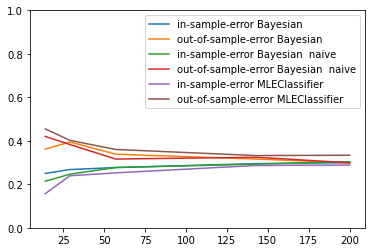

In [5]:
df = pd.read_csv('breast-cancer.csv').to_numpy()
X = df[:, :2]
Y = df[:, -1]

ax = plot_learning_curves(BayesianCategoricalClassifier(False),X,Y)
ax = plot_learning_curves(BayesianCategoricalClassifier(True),X,Y,ax)
ax = plot_learning_curves(MLEClassifier(),X,Y,ax)

- Which learner works best here?

The learner works best (by little) here, taking into account the learning curves, its the **Bayesian classifier** because of its in-sample error is closer to its out-of-sample, and its out-of-sample is less than the others (this last one is specially important) is less than the other learners.

- Look at the class distribution on the breast-cancer dataset. Do you think that the
performance of the learners is good? Explain!

In terms of results **Not much**, the obtained error is about 30%, which means that the predictions still failing a lot of times. In terms of time and space, for this case, yes. But the small time consumed is due more to the amount of data than the learners itself.

- Is there an important gap between the in-sample and validation learning curve? How do
you interpret this gap?

There is a gap, but **it's not big**. This gap exists because the in-sample error usually is less than the validation one, due to the hypothesis fits better the data we used to train the learner

**2.4.** Create the same 3-plot series for the symptoms dataset. Conduct the same kind of
analysis.

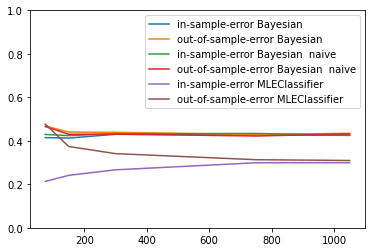

In [7]:
df = pd.read_csv('symptoms.csv').to_numpy()
X = df[:, :4]
Y = df[:, -1]
ax = plot_learning_curves(BayesianCategoricalClassifier(False),X,Y)
ax = plot_learning_curves(BayesianCategoricalClassifier(True),X,Y,ax)
ax = plot_learning_curves(MLEClassifier(),X,Y,ax)

- What do you find different to the performance on the breast-cancer dataset?
Do you think that other learners could do better on the data? Why or why not?

The biggest difference is that this time the best (by far) learner is the MLE classifier. It's evident that the other learners got a lot worse, while the MLE still having an error about 30%. We think that it's likely other learners that converge a little lower but better works do better on this data.

**2.5.**
Implement a class BayesianNumericalClassifier. It should receive a parameter is_naive
at initialization time to specify whether it should behave in a naive way. Models should
be learned assuming a joint normal distribution (you might want to look at np.cov and
scipy.stats.multivariate_normal.pdf).
Plot the learning curves of the full and naive Bayesian classifier on Iris.

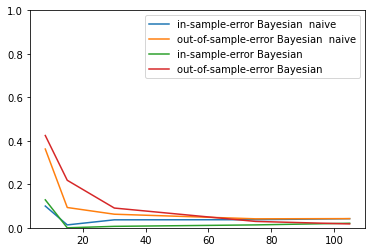

In [8]:
from scipy.stats import multivariate_normal

class BayesianNumericalClassifier:
    def __init__(self, is_naive):
        self.is_naive = is_naive
    def getName(self):
        return " Bayesian " +(' naive' if self.is_naive else '')
    def train(self, X, Y):
        self.D = {}
        for x, y in zip(X, Y):
            if y not in self.D.keys():
                self.D[y] = []
            self.D[y].append(x)
        self.n = {}
        self.Pc = {}
        self.miu = {}
        self.Z = {}
        self.cov = {}
        self.cov2 = {}
        for key in self.D:
            self.n[key] = len(self.D[key])
            self.Pc[key] = self.n[key]/len(X)
            self.miu[key] = (1/self.n[key]) * np.sum(self.D[key], axis=0)
            self.Z[key] = self.D[key]-self.miu[key].transpose()
            if not self.is_naive:
                self.cov[key] = 1/self.n[key] * np.dot(self.Z[key].transpose(), self.Z[key])
                self.cov[key] = self.cov[key].astype("float")
            else:
                self.cov[key] = {}
                d=len(self.Z[key][0])
                covMat = np.zeros((d,d))
                for i in range(d):
                    # cov for manual equation
                    self.cov[key][i] =  (1/self.n[key]) * np.dot(self.Z[key][:, i], self.Z[key][:, i].transpose())
                    # cov for ultivariate_normal.pdf
                    covMat[i][i]= (1/self.n[key]) * np.dot(self.Z[key][:, i], self.Z[key][:, i].transpose())
                self.cov2[key]=covMat

    def predict(self, X):
        resTotal = []
        for x in X:
            res = {}
            d = len(x)
            if not self.is_naive:
                for key in self.D:
                    # Error with singular matrix
                    # Fi = ((1/((math.sqrt(2*math.pi)**d) * np.sqrt(np.linalg.det(self.cov[key])))) * np.exp(-((x-self.miu[key]).transpose().dot(np.linalg.inv(self.cov[key])).dot((x-self.miu[key])))/2))
                    Fi = multivariate_normal.pdf(x, mean=self.miu[key], cov=self.cov[key],allow_singular=True)
                    Total = Fi * self.Pc[key]
                    res[key] = Total
            else:
                for key in self.D:
                    # Error with 0 in division
                    # Fi = 1
                    # for d in range(len(x)):
                    #         Fi *=((1/(math.sqrt(2*math.pi) * math.sqrt(self.cov[key][d]))) * np.exp(-((x[d]-self.miu[key][d])**2)/(2*self.cov[key][d])))
                    Fi = multivariate_normal.pdf(x, mean=self.miu[key], cov=self.cov2[key],allow_singular=True)
                    Total = Fi * self.Pc[key]
                    res[key] = Total
            resTotal.append(max(res, key=res.get))
        return resTotal

data = pd.read_csv('iris.csv').to_numpy()
X = data[:, :4]
Y = data[:, -1]
model.train(X,Y)

ax = plot_learning_curves(BayesianNumericalClassifier(True),X,Y)
ax = plot_learning_curves(BayesianNumericalClassifier(False),X,Y,ax)

- Which one is better? Explain!

The full version is better. It occurs because though the naive converge faster (with few data), the full version converge better after certain amount of data is used.